In [1]:
using Plots
using LightGraphs
using LinearAlgebra
using BenchmarkTools
using SparseArrays
using Random
using LaTeXStrings
using Flux
using GraphRecipes
using GraphPlot
using Random
using StatsBase
using Distributions
using OneHotArrays
using Statistics

In [2]:
function randomPopulateMat(mat,symmetric=true)
    for ii = 1:round(Int, percPopulate*size(mat)[1] )
        row_tmp = rand( 1:size(mat)[1] )
        col_tmp = rand( 1:size(mat)[1] )
        if( row_tmp == col_tmp )
            col_tmp = rand( deleteat!( collect(1:size(mat)[1]), row_tmp ) )            
        end
        mat[row_tmp,col_tmp] = 1
        if(symmetric == true)
            mat[col_tmp,row_tmp] = 1
        end
    end
    return mat
end

randomPopulateMat (generic function with 2 methods)

In [3]:
function A2S(AdjMat)
    AdjMat += I #add the identity to the diagonal, add self-loops
    diag = Diagonal(vec(sum(AdjMat,dims=2) .^ (-1/2)))
    return (diag) * AdjMat * (diag) #return the normalized S matrix
end

A2S (generic function with 1 method)

In [4]:
function A2k(SMat,k)
    return SMat^k
end

A2k (generic function with 1 method)

In [5]:
BenchmarkTools.DEFAULT_PARAMETERS.samples = 20
BenchmarkTools.DEFAULT_PARAMETERS.seconds = 5

5

In [6]:
benchmarkDicts = Dict()
benchmarkDicts["time"] = []
benchmarkDicts["memory"] = []
benchmarkDicts["gctime"] = []
benchmarkDicts["allocs"] = []
NN = [10^k for k in 1:5] #[10^1,10^2,10^3,10^4,10^5]
percPopulate = 0.1
for ii in 1:length(NN)
    NNtmp = NN[ii]
    AA = spzeros(NNtmp,NNtmp);
    AA = randomPopulateMat(AA);
    bb = @benchmark A2S($AA)
    push!(benchmarkDicts["time"],mean(bb).time)
    push!(benchmarkDicts["memory"],mean(bb).memory)
    push!(benchmarkDicts["gctime"],mean(bb).gctime)
    push!(benchmarkDicts["allocs"],mean(bb).allocs)
    
end

In [7]:
benchmarkDicts["time"]

5-element Array{Any,1}:
   1228.6078947368424
   5626.35
  48162.9
 492905.35
      4.5224228e6

In [8]:
benchmarkDicts["memory"]

5-element Array{Any,1}:
     2656
    14048
   124896
  1227712
 12261648

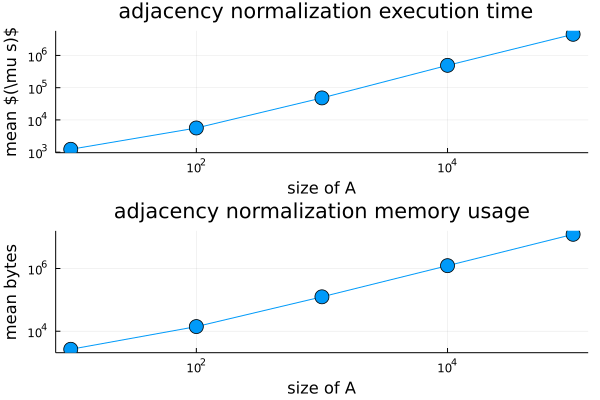

In [9]:
pTime = plot( NN , benchmarkDicts["time"] ,markershape=:circle, markersize=8 ,
        legend = false , xaxis=:log , yaxis=:log)
xlabel!("size of A")
ylabel!("mean " * L"(\mu s)")
title!(" adjacency normalization execution time")
pMemory = plot( NN , benchmarkDicts["memory"] ,markershape=:circle, markersize=8 ,
        legend = false , xaxis=:log , yaxis=:log)
xlabel!("size of A")
ylabel!("mean bytes")
title!("adjacency normalization memory usage")
plot(pTime, pMemory, layout = Plots.grid(2,1) )

In [10]:
benchmarkDicts_k = Dict()
benchmarkDicts_k["time"] = []
benchmarkDicts_k["memory"] = []
benchmarkDicts_k["gctime"] = []
benchmarkDicts_k["allocs"] = []
NN = [10^6]
percPopulate = 0.1
NNtmp = NN[1]
AA = spzeros(NNtmp,NNtmp);
AA = randomPopulateMat(AA);
AS = A2S(AA)
K = [0,1,2,3,4,6]
for ii in 1:length(K)
    kk = K[ii]
    bb = @benchmark A2k(AS,$kk)
    push!(benchmarkDicts_k["time"],mean(bb).time)
    push!(benchmarkDicts_k["memory"],mean(bb).memory)
    push!(benchmarkDicts_k["gctime"],mean(bb).gctime)
    push!(benchmarkDicts_k["allocs"],mean(bb).allocs)
    
end

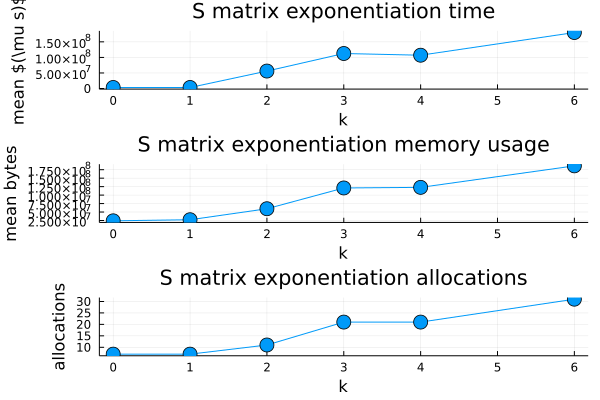

In [11]:
pTime = plot( K , benchmarkDicts_k["time"] ,markershape=:circle, markersize=8 ,
        legend = false )
xlabel!("k")
ylabel!("mean " * L"(\mu s)")
title!("S matrix exponentiation time")
pMemory = plot( K , benchmarkDicts_k["memory"] ,markershape=:circle, markersize=8 ,
        legend = false )
xlabel!("k")
ylabel!("mean bytes")
title!("S matrix exponentiation memory usage")
pAllocs = plot( K , benchmarkDicts_k["allocs"] ,markershape=:circle, markersize=8 ,
        legend = false )
xlabel!("k")
ylabel!("allocations")
title!("S matrix exponentiation allocations")
plot(pTime, pMemory, pAllocs, layout = Plots.grid(3,1) )

# generate the block diagonal data to experiment with

In [5]:
NN_set = [10^k for k in 2:4];

In [45]:
ER_BA_SF_WS_Block_graphs = Dict()
ER_BA_SF_WS_Block_matrices = Dict()
for nn in 1:length(NN_set)    
    
    NN_tmp = Int( NN_set[nn] / 4 )
    
    ER_tmp = erdos_renyi( NN_tmp , 10*(NN_tmp) )
    BA_tmp = barabasi_albert( NN_tmp , 8 )
    SF_tmp = static_scale_free( NN_tmp , 8*(NN_tmp) , 4 )
    WS_tmp = erdos_renyi( NN_tmp , 10*(NN_tmp) ) #barabasi_albert( NN_tmp , 5 )
    blocks_tmp = blockdiag( blockdiag( blockdiag(ER_tmp,BA_tmp),SF_tmp ), WS_tmp )
    
    ER_BA_SF_WS_Block_graphs[nn] = blockdiag( blockdiag( blockdiag(ER_tmp,BA_tmp),SF_tmp ), WS_tmp )
    #now add some edges between the blocks that are the communities
    #>>>>    
    for bb in 1:Int(round(NN_tmp/10))
        for b1 in 0:3
            for b2 in 0:3
                if(b1 < b2)
                    range1 = randperm(NN_tmp)[1] + b1*NN_tmp
                    range2 = randperm(NN_tmp)[1] + b2*NN_tmp
                    add_edge!( ER_BA_SF_WS_Block_graphs[nn] , range1 , range2 )
                end
            end
        end
    end
    #<<<<
    density_nn = LightGraphs.density(ER_BA_SF_WS_Block_graphs[nn])
    println("nn=$(nn), density=$(density_nn)")
end
[ ER_BA_SF_WS_Block_matrices[ii] = Matrix(adjacency_matrix(ER_BA_SF_WS_Block_graphs[ii])) for ii in 1:length(NN_set) ]
ER_BA_SF_WS_Block_graphs

nn=1, density=0.1713131313131313
nn=2, density=0.018190190190190192
nn=3, density=0.001828902890289029


Dict{Any, Any} with 3 entries:
  2 => {1000, 9086} undirected simple Int64 graph
  3 => {10000, 91436} undirected simple Int64 graph
  1 => {100, 848} undirected simple Int64 graph

In [7]:
[ is_connected( ER_BA_SF_WS_Block_graphs[ii] ) for ii in 1:length(NN_set) ]

3-element Vector{Bool}:
 1
 1
 1

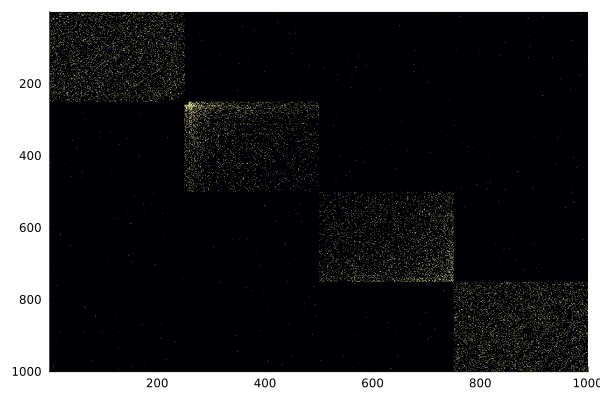

In [8]:
heatmap( ER_BA_SF_WS_Block_matrices[2] , yflip = true , legend = false )

# generate the X and Y variable data

In [58]:
d1 = Dirichlet( [10,10,10] )
c1 = Categorical( [0.5,0.25,0.25] )
d2 = Dirichlet( [20,10,10] )
c2 = Categorical( [0.35,0.35,0.3] )
d3 = Dirichlet( [20,10,10] )
c3 = Categorical( [0.25,0.25,0.5] )

Categorical{Float64, Vector{Float64}}(support=Base.OneTo(3), p=[0.25, 0.25, 0.5])

In [59]:
networks_X = Dict()
networks_Y = Dict()
networks_Y_cold = Dict()

for nn in 1:length(NN_set)
    
    NN_tmp = Int( NN_set[nn] / 4 )
    
    xd1 = rand( d1 , NN_tmp )
    xc1 = onehotbatch( rand( c1 , NN_tmp ) , 1:3 )
    x1a = vcat( xd1 , xc1 )'
    xd1 = rand( d1 , NN_tmp )
    xc1 = onehotbatch( rand( c1 , NN_tmp ) , 1:3 )
    x1b = vcat( xd1 , xc1 )'
    xd2 = rand( d2 , NN_tmp )
    xc2 = onehotbatch( rand( c2 , NN_tmp ) , 1:3 )
    x2 = vcat( xd2 , xc2 )'
    xd3 = rand( d3 , NN_tmp )
    xc3 = onehotbatch( rand( c3 , NN_tmp ) , 1:3 )
    x3 = vcat( xd3 , xc3 )'
    xc3 = onehotbatch( rand( c3 , NN_tmp ) , 1:3 )
    x3 = vcat( xd3 , xc3 )'

    networks_X[nn] = vcat( x1a , x1b , x2 , x3 )
    
    y1a = onehotbatch( 1*ones(NN_tmp) , 1:3 )'
    y1b = onehotbatch( 1*ones(NN_tmp) , 1:3 )'
    y2 = onehotbatch( 2*ones(NN_tmp) , 1:3 )'
    y3 = onehotbatch( 3*ones(NN_tmp) , 1:3 )'
    
    networks_Y[nn] = vcat( y1a , y1b , y2 , y3 )
    networks_Y_cold[nn] = vcat(1*ones(NN_tmp),1*ones(NN_tmp),2*ones(NN_tmp),3*ones(NN_tmp))
       
end


In [12]:
networks_X[1]

100×6 Matrix{Float64}:
 0.959582    0.0211499    0.0192685   1.0  0.0  0.0
 0.862213    0.056595     0.0811919   1.0  0.0  0.0
 0.982063    0.0091251    0.00881197  1.0  0.0  0.0
 0.880616    0.0775518    0.0418318   1.0  0.0  0.0
 0.814811    0.143701     0.041488    1.0  0.0  0.0
 0.851116    0.0235455    0.125338    1.0  0.0  0.0
 0.863734    0.0304501    0.105816    1.0  0.0  0.0
 0.936311    0.0458552    0.0178341   1.0  0.0  0.0
 0.818332    0.134081     0.0475869   1.0  0.0  0.0
 0.982715    0.0159712    0.00131377  1.0  0.0  0.0
 0.896742    0.00793885   0.0953196   1.0  0.0  0.0
 0.945598    0.00301431   0.0513879   1.0  0.0  0.0
 0.913141    0.0502179    0.036641    1.0  0.0  0.0
 ⋮                                              ⋮
 0.00322476  0.0309965    0.965779    0.0  0.0  1.0
 0.0503119   0.00536395   0.944324    0.0  0.0  1.0
 0.054986    0.0125583    0.932456    0.0  0.0  1.0
 0.0365835   0.000828871  0.962588    0.0  0.0  1.0
 0.0138167   0.0196207    0.966563    0.0  

In [13]:
networks_X[1]'

6×100 adjoint(::Matrix{Float64}) with eltype Float64:
 0.959582   0.862213   0.982063    …  0.0417828   0.0786938   0.0175552
 0.0211499  0.056595   0.0091251      0.00151731  0.00904995  0.0218312
 0.0192685  0.0811919  0.00881197     0.9567      0.912256    0.960614
 1.0        1.0        1.0            0.0         0.0         0.0
 0.0        0.0        0.0            0.0         0.0         0.0
 0.0        0.0        0.0         …  1.0         1.0         1.0

In [14]:
networks_Y[1]'

3×100 adjoint(::Matrix{Bool}) with eltype Bool:
 1  1  1  1  1  1  1  1  1  1  1  1  1  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     1  1  1  1  1  1  1  1  1  1  1  1

In [15]:
networks_Y_cold[1]'

1×100 adjoint(::Vector{Float64}) with eltype Float64:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  …  3.0  3.0  3.0  3.0  3.0  3.0  3.0

In [16]:
sum( networks_Y_cold[1] .== 2 )

25

In [17]:
ER_BA_SF_WS_Block_matrices[1] * networks_X[1]

100×6 Matrix{Float64}:
 19.2998    0.749382   0.950778  21.0  0.0   0.0
 18.3432    0.833717   0.823054  20.0  0.0   0.0
 21.933     0.961316   1.10564   24.0  0.0   0.0
 18.2977    0.699964   1.00238   20.0  0.0   0.0
 22.1029    0.765834   1.1313    24.0  0.0   0.0
 18.299     0.764293   0.93671   20.0  0.0   0.0
 18.2153    0.816875   0.967802  20.0  0.0   0.0
 19.3095    1.74025    0.950228  21.0  1.0   0.0
 20.1776    1.67864    1.14372   22.0  1.0   0.0
 15.4322    0.752591   0.815166  17.0  0.0   0.0
 16.4613    0.784848   0.753832  18.0  0.0   0.0
 16.3915    0.725485   0.882979  18.0  0.0   0.0
 22.0045    0.859317   1.13614   24.0  0.0   0.0
  ⋮                                          ⋮
  0.51557   0.605849  15.8786     0.0  0.0  17.0
  1.56736   0.83568   18.597      1.0  0.0  20.0
  0.518318  0.71805   18.7636     0.0  0.0  20.0
  0.572407  0.638152  15.7894     0.0  0.0  17.0
  0.743325  0.817402  20.4393     0.0  0.0  22.0
  0.61267   0.737293  17.65       0.0  0.0  19.0

In [18]:
#normalize adjacency first
( A2S(ER_BA_SF_WS_Block_matrices[1]) * networks_X[1] )'

6×100 adjoint(::Matrix{Float64}) with eltype Float64:
 0.939994   0.902855   1.01827    …  0.0252376  0.0310699  0.0360498
 0.0345829  0.0408707  0.0424779     0.0372865  0.0392136  0.0394488
 0.045078   0.0424383  0.0492312     0.88786    0.923467   0.934604
 1.01966    0.986164   1.10998       0.0        0.0        0.0
 0.0        0.0        0.0           0.0        0.0        0.0
 0.0        0.0        0.0        …  0.950384   0.99375    1.0101

In [38]:
size(Ydata)

(100,)

In [65]:
nn = 2

Xdata = networks_X[nn]'
X_dim = size(Xdata)[1]
display(X_dim)
# (ER_BA_SF_WS_Block_matrices[nn] * networks_X[1])' # 6 x 100
Xdata_Conv = ( (A2S(ER_BA_SF_WS_Block_matrices[nn])^0) * networks_X[nn] )'

#display(XdataTest[:,1:10]); display(XdataTest[:,end-10:end])
Ydata = networks_Y_cold[nn]
Y_dim = 3 #size(Ydata)[1]
#println(Ydata[1:10]);println(Ydata[end-10:end]);
println("one hot ?..")
Ydata_1Hot = onehotbatch( Ydata , [1,2,3] )
display(Ydata_1Hot)
#display(YdataTest[:,1:10]); display(YdataTest[:,end-10:end])

modelSGC = Chain( Dense( X_dim => Y_dim ) , softmax )
lossSGC(x,y) = Flux.crossentropy( modelSGC(x) , y )

optim = Adam( 0.01 );
pars = Flux.params( modelSGC )
data = Flux.DataLoader( (Xdata_Conv, Ydata_1Hot) , batchsize=10 , shuffle=true )
for epoch in 1:500
    #Flux.train!( lossSGC , pars , data , optim )
    Flux.train!(pars, data, opt) do x, y
        Flux.crossentropy(modelSGC(x), y)
    end
end

mean( onecold( modelSGC(Xdata_Conv), [1,2,3] ) .== Ydata )

6

one hot ?..


3×1000 OneHotMatrix(::Vector{UInt32}) with eltype Bool:
 1  1  1  1  1  1  1  1  1  1  1  1  1  …  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     1  1  1  1  1  1  1  1  1  1  1  1

0.666

In [55]:
onecold( modelSGC(Xdata_Conv), [1,2,3] )

1000-element Vector{Int64}:
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 ⋮
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1

In [20]:
XdataTest = hcat( repeat( [1,0,0,0,1,0] , 1 , 50 ) , repeat( [0,1,0,0,1,0] , 1 , 25 ) , repeat( [0,0,1,0,1,0] , 1 , 25 ) )
display(XdataTest[:,1:10]); display(XdataTest[:,end-10:end])
Ydata = append!(repeat( [1] , 50 ) , repeat( [2] , 25 ) , repeat( [3] , 25 ) )
println(Ydata[1:10]);println(Ydata[end-10:end]);
YdataTest = onehotbatch( Ydata , [ 1 , 2 , 3 ] )
display(YdataTest[:,1:10]); display(YdataTest[:,end-10:end])

modelTest = Chain( Dense( 6 => 3 ) , softmax )
lossTest(x,y) = Flux.crossentropy(modelTest(x), y)

optimTest = Adam(0.01);
parsTest = Flux.params(modelTest)
dataTest = Flux.DataLoader( (XdataTest, YdataTest) , batchsize=15 , shuffle=true )
for epoch in 1:200
    Flux.train!(lossTest , parsTest , dataTest, optimTest)
end

6×10 Matrix{Int64}:
 1  1  1  1  1  1  1  1  1  1
 0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0
 1  1  1  1  1  1  1  1  1  1
 0  0  0  0  0  0  0  0  0  0

6×11 Matrix{Int64}:
 0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0
 1  1  1  1  1  1  1  1  1  1  1
 0  0  0  0  0  0  0  0  0  0  0
 1  1  1  1  1  1  1  1  1  1  1
 0  0  0  0  0  0  0  0  0  0  0

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]


3×10 OneHotMatrix(::Vector{UInt32}) with eltype Bool:
 1  1  1  1  1  1  1  1  1  1
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅

3×11 OneHotMatrix(::Vector{UInt32}) with eltype Bool:
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 1  1  1  1  1  1  1  1  1  1  1

In [22]:
println(onecold(modelTest(XdataTest),[1,2,3]))

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]


In [23]:
println(onecold(YdataTest,[1,2,3]))

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]


In [24]:
mean( onecold(modelTest(XdataTest),[1,2,3]) .== onecold(YdataTest,[1,2,3]) )

1.0

In [25]:
Flux.crossentropy( [0.3,0.6,0.1] , 2 )

8.034767042171937

In [26]:
Flux.crossentropy( [0.8,0.1,0.1] , Flux.onehotbatch( [2] , [1,2,3] ) )

2.3025850929940432

In [27]:
Flux.crossentropy( [0.8,0.1,0.1] , [0,1,0] )

2.3025850929940432

In [29]:

nn = 1
optim = Adam(0.01);
y_D_num = size(networks_Y[nn])[2] # 3
x_feature_num = size(networks_X[nn])[2] # 6
Ydata = networks_Y[nn]'

Xdata = networks_X[1]' # (ER_BA_SF_WS_Block_matrices[nn] * networks_X[1])' # 6 x 100
Xdata

6×100 adjoint(::Matrix{Float64}) with eltype Float64:
 0.959582   0.862213   0.982063    …  0.0417828   0.0786938   0.0175552
 0.0211499  0.056595   0.0091251      0.00151731  0.00904995  0.0218312
 0.0192685  0.0811919  0.00881197     0.9567      0.912256    0.960614
 1.0        1.0        1.0            0.0         0.0         0.0
 0.0        0.0        0.0            0.0         0.0         0.0
 0.0        0.0        0.0         …  1.0         1.0         1.0

In [34]:
#this is a basic testing function set which resembles the SGC approach
X = rand(6, 100)
display(X[:,1:10])
truth = []
for col in eachcol(X)
    if( sum(col) < 2.2 )
        append!(truth,1)
    elseif( sum(col) > 3.25)
        append!(truth,3)
    else
        append!(truth,2)
    end
end
display(truth[1:10]')
model = Chain(Dense(6 => 3), softmax)

Y = Flux.onehotbatch( truth , [1,2,3] ) # Flux.onehotbatch( truth , [true, false] )

display(Y[:,1:10])
data = Flux.DataLoader((X, Y), batchsize=15, shuffle=true);

pars = Flux.params(model)
opt = Flux.Adam(0.01)
for epoch in 1:200
    Flux.train!(pars, data, opt) do x, y
        Flux.crossentropy(model(x), y)
    end
end

predictions = model(X)
display( predictions[:,1:10] )
display( mean( onecold( predictions,[1,2,3] ) .== truth ) )
display( mean( onecold( predictions,[1,2,3] ) .== onecold(Y,[1,2,3]) ) )

6×10 Matrix{Float64}:
 0.715999   0.254652  0.486177  0.639516  …  0.0838244  0.741008  0.213033
 0.551237   0.232586  0.805436  0.020911     0.703908   0.478706  0.599643
 0.809851   0.131874  0.894892  0.982884     0.956237   0.427818  0.379515
 0.642838   0.490083  0.989935  0.527355     0.821153   0.179571  0.673733
 0.0791379  0.433722  0.668326  0.954746     0.905022   0.551002  0.353324
 0.138115   0.997851  0.296197  0.83429   …  0.144961   0.416526  0.92633

1×10 adjoint(::Vector{Any}) with eltype Any:
 2  2  3  3  1  2  3  3  2  2

3×10 OneHotMatrix(::Vector{UInt32}) with eltype Bool:
 ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅
 1  1  ⋅  ⋅  ⋅  1  ⋅  ⋅  1  1
 ⋅  ⋅  1  1  ⋅  ⋅  1  1  ⋅  ⋅

3×10 Matrix{Float64}:
 0.0486159  0.0887719  0.00296049  …  0.00610607  0.146908  0.0221382
 0.766256   0.770676   0.182464       0.223218    0.618576  0.768172
 0.185128   0.140552   0.814576       0.770676    0.234516  0.20969

0.85

0.85

In [72]:
@benchmark A2S(AA)

BenchmarkTools.Trial: 100 samples with 6 evaluations.
 Range (min … max):   6.906 μs …  14.133 μs  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):      9.935 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   10.012 μs ± 751.256 ns  ┊ GC (mean ± σ):  0.00% ± 0.00%

                             ▂█▃▆▂▆█▂  ▅ █                      
  ▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▄▄▁▁▁▁▁▁▇███████████▇█▅▇▄▅▄▁▁▁▁▁▁▁▁▁▁▄▁▁▁▄ ▄
  6.91 μs         Histogram: frequency by time         12.4 μs <

 Memory estimate: 13.77 KiB, allocs estimate: 22.